In [1]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# 이미지 불러오기  (-1 : 이미지 그대로 불러오기, 0 : 흑백으로 불러오기, 1 : 알파 채널 무시한 컬러 이미지 불러오기)
src = cv2.imread('./Data/Student ID Card1.jpg', -1)

# 화면 크기 x축, y축 0.5배로 줄이기  - 내 모니터 화면보다 이미지가 크게 나와서 조정 필요
src = cv2.resize(src, (0, 0), fx=0.5, fy=0.5)

# resize된 이미지의 크기를 확인해보기 위해 사용 src.shape(h, w, c), x2하면 원본 크기 알 수 있음
print(src.shape)

if src is None:
    print('Image load failed!')
    sys.exit()

# 이미지 출력 - 원본 컬러 이미지 그대로 출력
cv2.imshow('src', src)
cv2.waitKey(0)
cv2.destroyAllWindows()

(693, 520, 3)


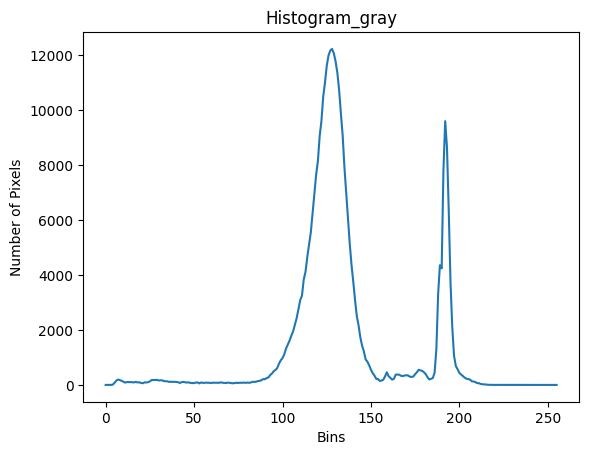

In [2]:
# 흑백으롭 변경
# 더 간단하게 이미지를 인식하기 위해 채널을 1로 변경
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# 히스토그램 계산
# 흑백 이미지의 채널에 따른 픽셀수의 히스토그램을 시각화시켜 확인해보고 싶어서 실행
hist_gray = cv2.calcHist([src_gray], [0], None, [256], [0, 256])

# 히스토그램 그래프 시각화
plt.plot(hist_gray)
plt.title('Histogram_gray')
plt.xlabel('Bins')  # 명암 값
plt.ylabel('Number of Pixels')   # 픽셀 수
plt.show()

# 흑백 이미지 출력
cv2.imshow('src_gray', src_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

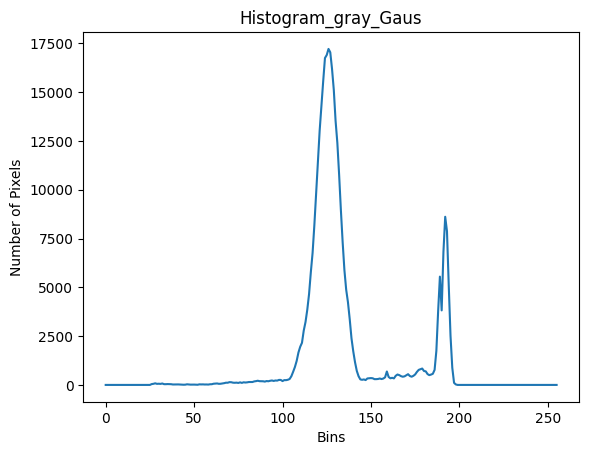

In [3]:
# 가우시안 블러 적용 / 노이즈 제거를 위해
# 이미지의 색수차를 줄여 색상간의 경계선을 흐릿하게 만들어 이미지를 부드럽게 만들어 노이즈 제거하기 위함
# 단, 이 때 가우시안 블러를 많이 적용할 수록 흐릿해짐
src_blurred = cv2.GaussianBlur(src_gray, ksize=(7, 7), sigmaX=0)

# 히스토그램 계산
# 노이즈 제거된 이미지의 채널에 따른 픽셀수의 히스토그램을 시각화시켜 확인해보고 싶어서 실행
hist_gray_Gaus = cv2.calcHist([src_blurred], [0], None, [256], [0, 256])

# 히스토그램 그래프 시각화
plt.plot(hist_gray_Gaus)
plt.title('Histogram_gray_Gaus')
plt.xlabel('Bins')  # 명암 값
plt.ylabel('Number of Pixels')   # 픽셀 수
plt.show()

# 가우시안 블러 처리 된 이미지 출력
cv2.imshow('src_blurred', src_blurred)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
# 흑백이미지와 가우시안블러 처리 된 이미지를 각각 이진화
# 블러 처리의 유무, 즉 노이즈 제거의 유무에 따른 이진화 이미지 차이를 관찰하기 위함
# 블러처리가 되지 않은 흑백이미지의 이진화 이미지
ret, src_thresh_gray = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU )

# 가우시안 블러 처리 된 이미지를 이진화
ret, src_thresh_blur = cv2.threshold(src_blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU )

# 가우시안 블러 처리 된 이미지의 이진화 이미지 출력
cv2.imshow('src_thresh_gray', src_thresh_gray)
cv2.imshow('src_thresh_blur', src_thresh_blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

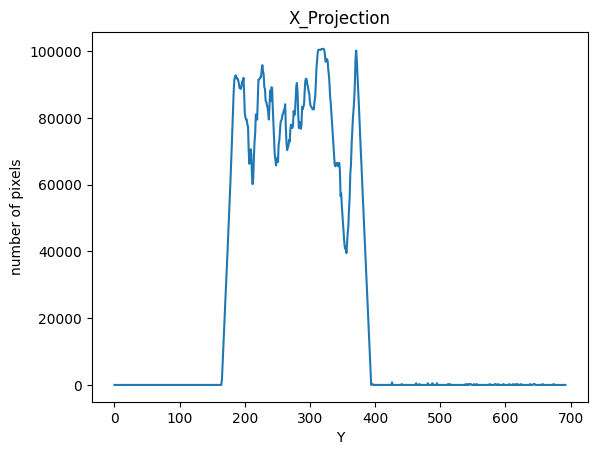

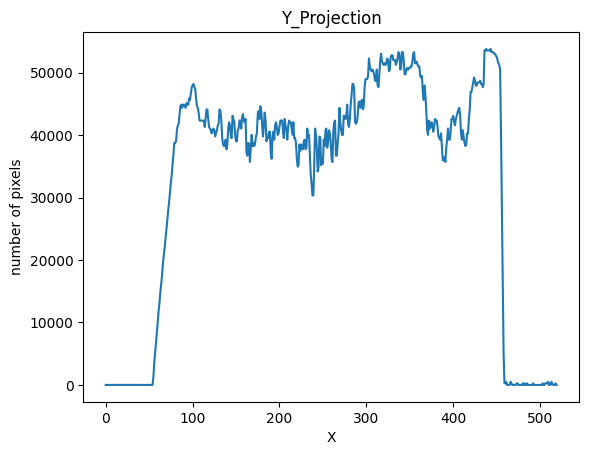

In [5]:
## 수직투사와 수평투사로 각각 y축, x축에 대한 픽셀값들의 히스토그램을 시각화
# 학생증의 대략적인 위치를 잡기 위함.

# 가우시안 블러를 사용하면 학생증은 인식 잘 될 것 같긴한데 글자가 찌그러짐. 
# 따라서 안 쓸 계획
# 가우시안 블러 처리하지 않은 이진화 이미지의 x축, y축 각각에 대한 픽셀값들의 히스토그램

# X축 프로젝션 (행별 합계)
# X축 (1 ~ 255)의 인덱스 1 부터 인덱스 255까지의 각각의 인덱스의 모든 Y축의 픽셀값들의 합
x_projection = np.sum(src_thresh_gray, axis=1)

# Y축 프로젝션 (열별 합계)
# Y축 (1 ~ 255)의 인덱스 1 부터 인덱스 255까지의 각각의 인덱스의 모든 X축의 픽셀값들의 합
y_projection = np.sum(src_thresh_gray, axis=0)

# X축 히스토그램
plt.plot(x_projection)
plt.xlabel('Y')
plt.ylabel('number of pixels')
plt.title('X_Projection')
plt.show()

# Y축 히스토그램
plt.plot(y_projection)
plt.xlabel('X')
plt.ylabel('number of pixels')
plt.title('Y_Projection')
plt.show()

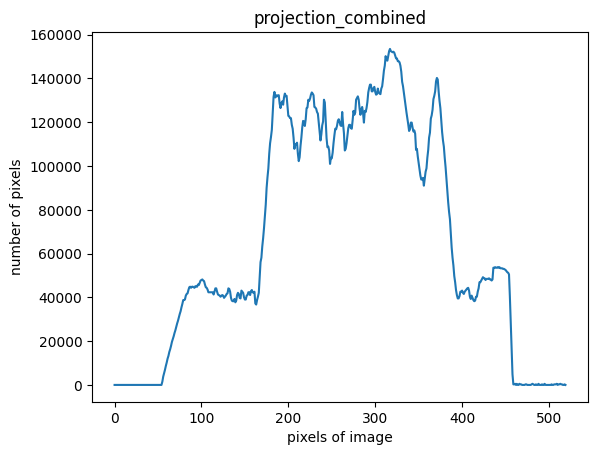

In [6]:
# 학생증의 대략적인 위치를 잘라내기 위해선 x축 프로젝션 값과 y축 프로젝션 값의 공통 부분을 찾아서 잘라내야 된다고 생각함.
# 따라서 x축 프로젝션과 y축 프로젝션을 더해 공통된 부분만 추출했을 때의 결과 값을 이용할 수 있지 않을까 생각함.

# x축, y축에 대한 프로젝션 결과를 합치기 위해서 배열의 크기를 동일하게 만들어야함.
# 배열의 크기 맞추기
min_size = min(len(x_projection), len(y_projection))
x_projection = x_projection[:min_size]
y_projection = y_projection[:min_size]
projection_combined = x_projection + y_projection

plt.plot(projection_combined)
plt.xlabel('pixels of image')
plt.ylabel('number of pixels')
plt.title('projection_combined')
plt.show()

In [7]:
# 노이즈 값들을 대강 n개라 설정 후 n개 이상인 영역을 잘라내보기
# 대략적으로 학생증을 잘라내기 위함.

# 1번. y축 프로젝션 값을 이용해 x축 범위 잘라내기
# 2번. x축 프로젝션 값을 이용해 y축 범위 잘라내기
# 3번. x축 프로젝션 + y축 프로젝션 두 값을 더한 걸로 학생증만 대강 잘라내기

# 1번. y축 프로젝션 값을 이용해 x축 범위 잘라내기

# 픽셀값이 n개 이상인 영역 식별
n = 2000 # n개 이상의 픽셀값을 가진 영역 식별
indices = np.where(y_projection >= n)[0]
# start = 픽셀 값이 n개 이상인 영역의 첫 인덱스
# end = 픽셀 값이 n개 이상인 영역의 마지막 인덱스
# 픽셀값이 n개 이상인 범위를 잘라내기 위해 start값과 end값 구함
start_y = indices[0]
end_y = indices[-1]

# 역투영 생성
Backprojection_y_projection = np.zeros_like(src_gray)
Backprojection_y_projection[:, start_y:end_y] = src_gray[:, start_y:end_y]

cv2.imshow('Original Image', src_gray)
cv2.imshow('Backprojection_Y_Projection', Backprojection_y_projection)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
# 2번. x축 프로젝션 값을 이용해 x축 범위 잘라내기

# 픽셀값이 n개 이상인 영역 식별
n = 2000 # n개 이상의 픽셀값을 가진 영역 식별
indices = np.where(x_projection >= n)[0]
# start = 픽셀 값이 n개 이상인 영역의 첫 인덱스
# end = 픽셀 값이 n개 이상인 영역의 마지막 인덱스
# 픽셀값이 n개 이상인 범위를 잘라내기 위해 start값과 end값 구함
start_x = indices[0]
end_x = indices[-1]

# 역투영 생성
Backprojection_x_projection = np.zeros_like(src_gray)
Backprojection_x_projection[start_x:end_x, :] = src_gray[start_x:end_x, :]

cv2.imshow('Original Image', src_gray)
cv2.imshow('Backprojection_X_Projection', Backprojection_x_projection)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
# 3번. x축 프로젝션 + y축 프로젝션 두 값을 더한 걸로 학생증만 대강 잘라내기

# 픽셀값이 n개 이상인 영역 식별
n = 2000 # n개 이상의 픽셀값을 가진 영역 식별
indices = np.where(projection_combined >= n)[0]
# start = 픽셀 값이 n개 이상인 영역의 첫 인덱스
# end = 픽셀 값이 n개 이상인 영역의 마지막 인덱스
# 픽셀값이 n개 이상인 범위를 잘라내기 위해 start값과 end값 구함
start = indices[0]
end = indices[-1]

# 역투영 생성
Backprojection_combined = np.zeros_like(src_gray)
Backprojection_combined[start_x:end_x, start_y:end_y] = src_gray[start_x:end_x, start_y:end_y]

cv2.imshow('Original Image', src_gray)
cv2.imshow('Backprojection_X_Projection', Backprojection_combined)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
# 외곽선 찾기
contours, _ = cv2.findContours(src_thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print(len(contours))

for pts in contours: # pts = numpy.ndarray (K * 1 * 2 로 되어있음)
    if cv2.contourArea(pts) < 1000:
        continue
            
    # 외곽선 근사화(단순화)
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)
    
    # 컨벡스가 아니면 제외
    if not cv2.isContourConvex(approx) or len(approx) != 4:
        continue
        
    cv2.polylines(Backprojection_combined, pts, True, (255, 0, 255), 2)  # 닫힌 외곽선이면 True, 컬러는 (b, g, r) 

cv2.imshow('contours', Backprojection_combined)
cv2.waitKey(0)
cv2.destroyAllWindows()

42


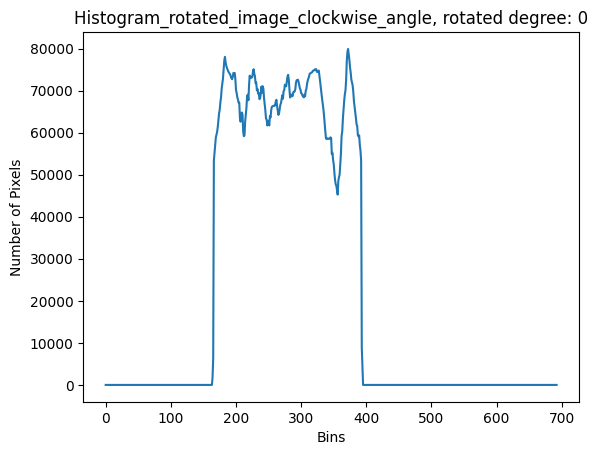

최대 픽셀 수 :  79908
돌아간 각도 :  0


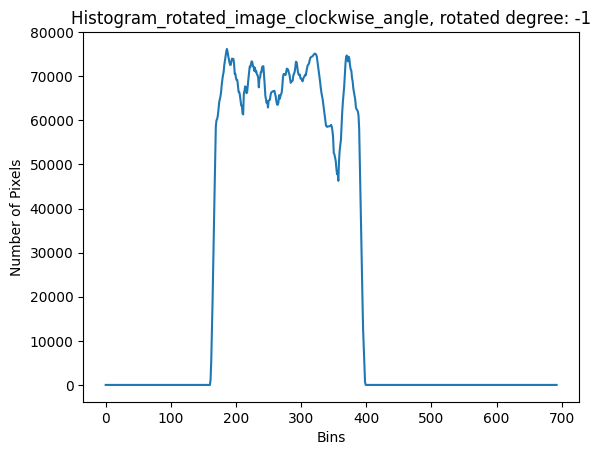

최대 픽셀 수 :  76197
돌아간 각도 :  -1


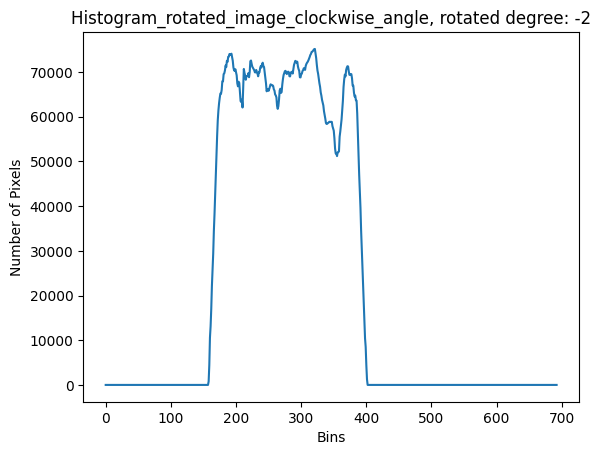

최대 픽셀 수 :  75183
돌아간 각도 :  -2


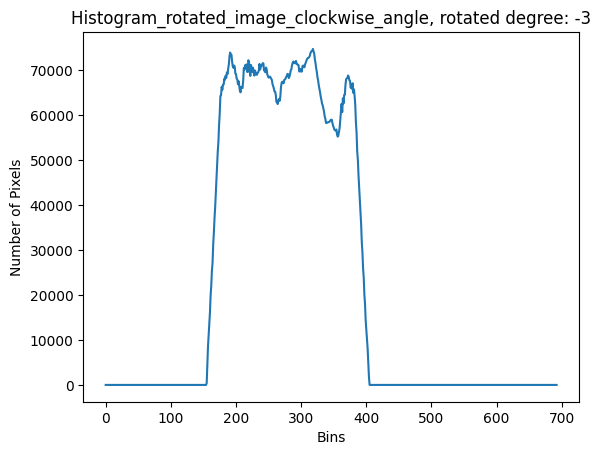

최대 픽셀 수 :  74801
돌아간 각도 :  -3


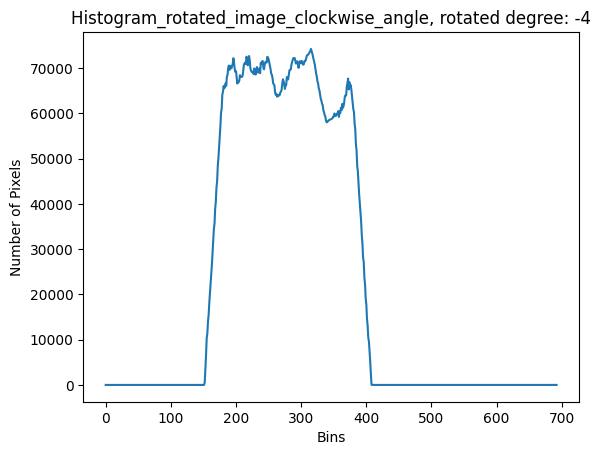

최대 픽셀 수 :  74210
돌아간 각도 :  -4


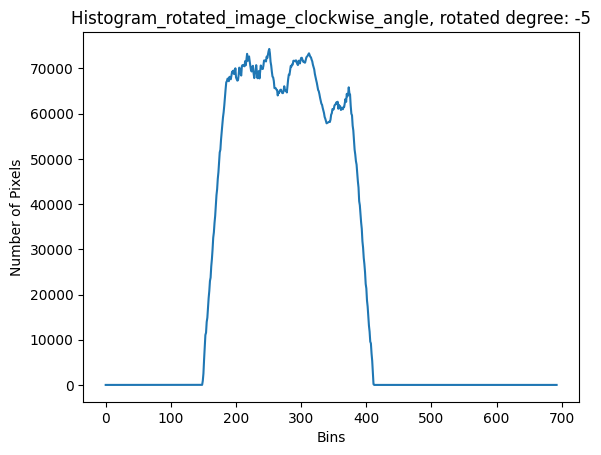

최대 픽셀 수 :  74324
돌아간 각도 :  -5


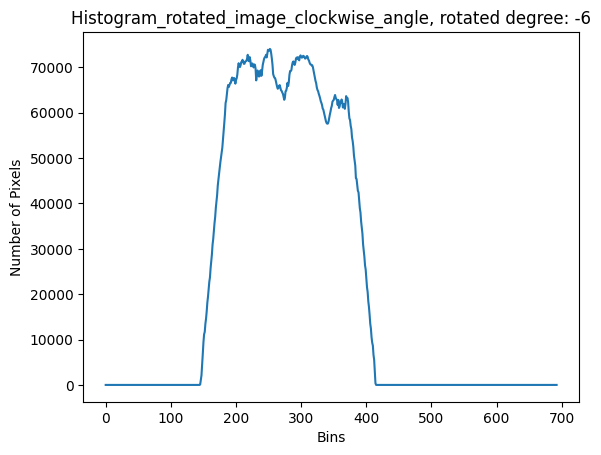

최대 픽셀 수 :  74070
돌아간 각도 :  -6


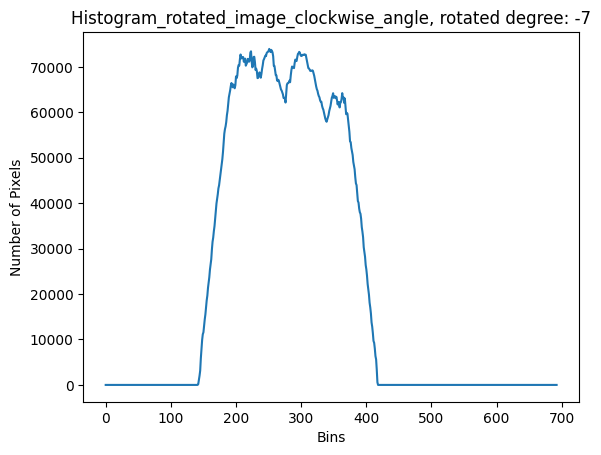

최대 픽셀 수 :  73951
돌아간 각도 :  -7


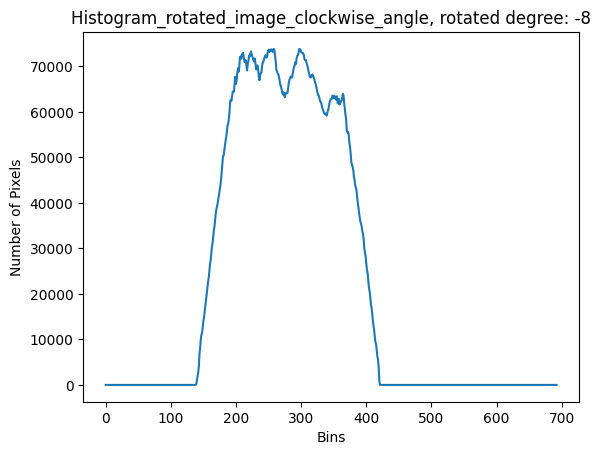

최대 픽셀 수 :  73856
돌아간 각도 :  -8


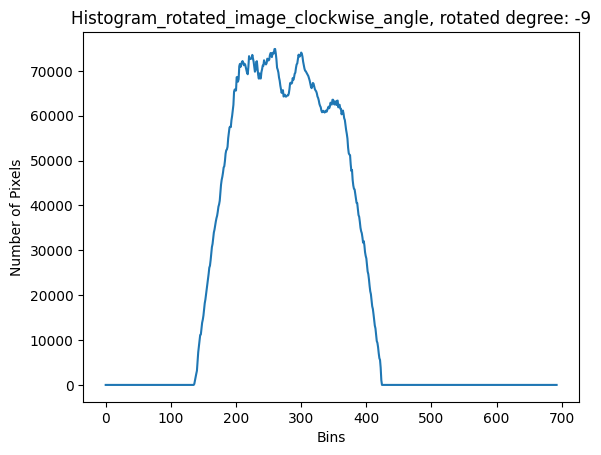

최대 픽셀 수 :  74899
돌아간 각도 :  -9


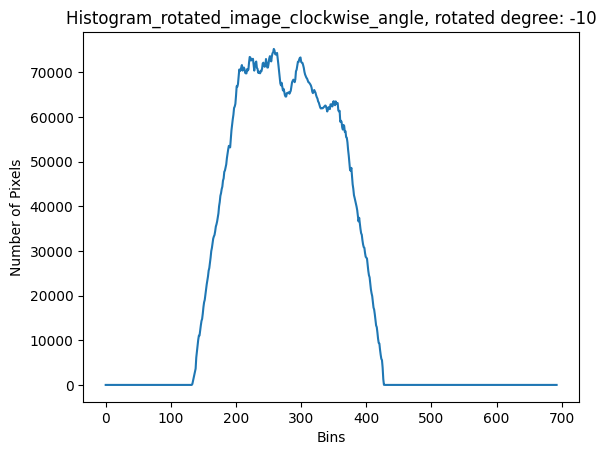

최대 픽셀 수 :  75223
돌아간 각도 :  -10


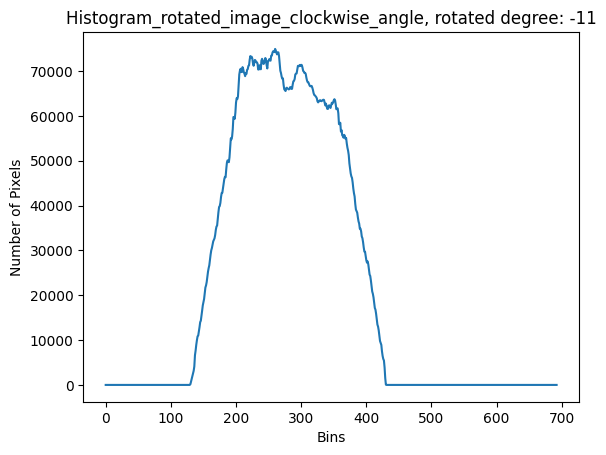

최대 픽셀 수 :  74913
돌아간 각도 :  -11


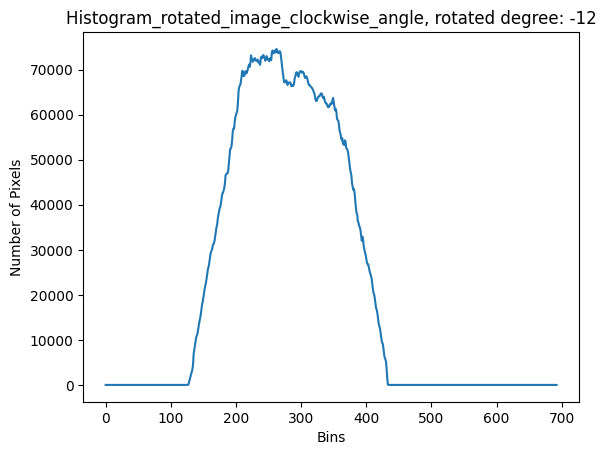

최대 픽셀 수 :  74607
돌아간 각도 :  -12


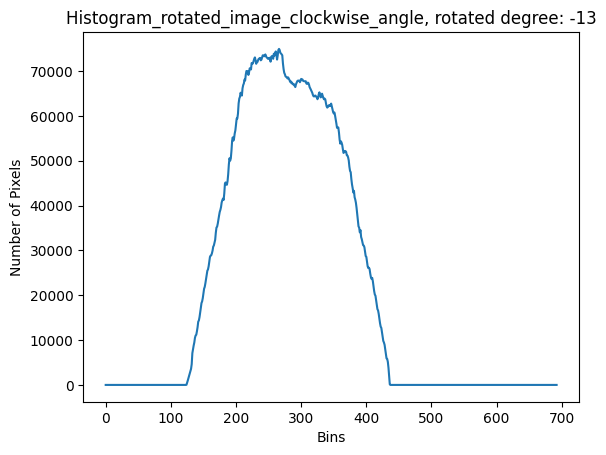

최대 픽셀 수 :  74952
돌아간 각도 :  -13


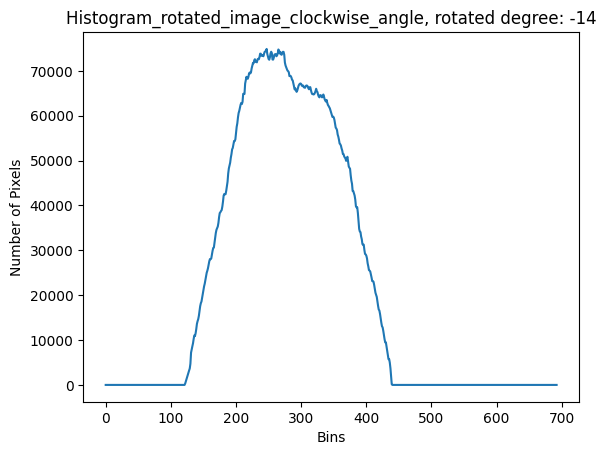

최대 픽셀 수 :  74883
돌아간 각도 :  -14


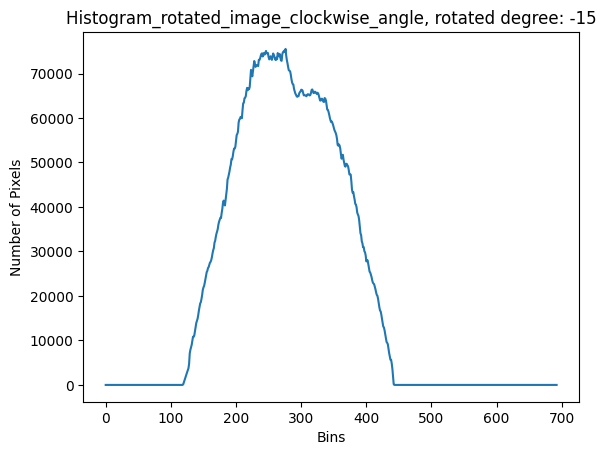

최대 픽셀 수 :  75531
돌아간 각도 :  -15


In [11]:
# 픽셀값이 n개 이상인 영역으로 추출하면 대략적인 학생증 위치마저 안나옴.
# 따라서 위의 방법보단 아래의 방법을 사용할 예정
# 이미지를 회전시키고 윤곽선을 딴 후 이미지 역투영을 통해 학생증만 확대시킬 것.

# 이미지의 크기를 잡고 이미지의 중심을 계산
(cX, cY) = (src.shape[1] / 2, src.shape[0] / 2)

# 회전 각도에 따른 max_peak 값을 저장할 리스트 초기화
# 시계, 반시계 방향으로 각각 0도 ~ 15도이니 총 32자리 필요
max_peak_value_rotated_x = [0] * 32

# 이미지를 중심으로 이미지를 -15 ~ 15까지 1도씩 회전하는 걸 반복
# 1. 이미지를 반시계 방향으로 0도 ~ 15도 / 2. 이미지를 시계 방향으로 0도 ~ 15도 두 가지 경우로 나눠서 진행
# 이때 반시계 방향으로 회전할 때 +1도씩이라 가정하고 
# 시계방향으로 회전할 때 -1 도씩이라 가정


# 1. 이미지를 시계방향으로 0도에서 15도까지 1도씩 회전하는 걸 반복
# x축 프로젝션 히스토그램의 max_peak값을 계속 저장하여 1도씩 돌아간 max_peak값 비교
# 가장 큰 max_peak값이 나왔을때가 정방향이라 가정
for i in range(0, -16, -1):
    M = angle_rotated_i = cv2.getRotationMatrix2D((cX, cY), i, 1)
    rotated_image = cv2.warpAffine(Backprojection_combined, M, (0, 0))
    rotate_x_projection = np.sum(rotated_image, axis=1)
    
    # 히스토그램 그래프에서 봉우리(peak) 값 찾기
    # 최대 peak 값을 찾기위해 모든 peak를 구하기 
    peaks_rotated_x, _ = find_peaks(rotate_x_projection.flatten(), prominence=0.1)
    peak_values_rotated_x = rotate_x_projection[peaks_rotated_x]

    # 가장 큰 봉우리 찾고 찾기
    # 모든 max_peak들을 서로 비교하기 위해 각각 max_peak_value_rotated_x[i]에 저장
    max_peak_value_rotated_x[i] = np.max(peak_values_rotated_x)
    # 몇 도 돌아갔을 때 가장 큰 값을 가지는지 확인하기위해서 i 값을 변수에 저장
    angle = i
    
    # 히스토그램 그래프 시각화
    plt.plot(rotate_x_projection)
    plt.title('Histogram_rotated_image_clockwise_angle, rotated degree: {}'.format(angle))
    plt.xlabel('Bins')  # 명암 값
    plt.ylabel('Number of Pixels') # 픽셀 수
    plt.show()
    
    # max_peak_value_rotated_x 값이 궁금해서 출력하여 확인해봄 
    print("최대 픽셀 수 : ", max_peak_value_rotated_x[i])
    print("돌아간 각도 : ", angle)

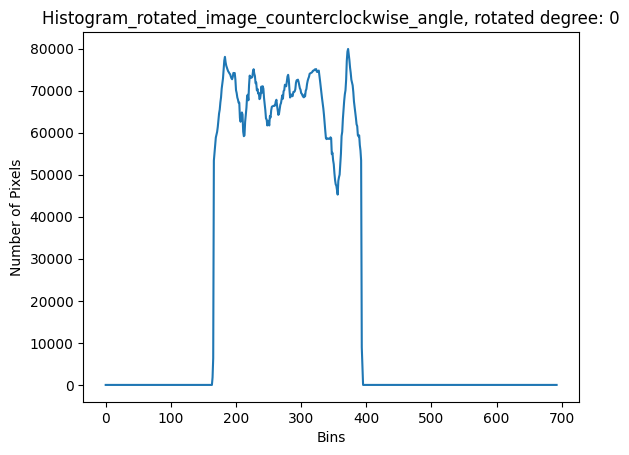

최대 픽셀 수 :  79908
돌아간 각도 :  0


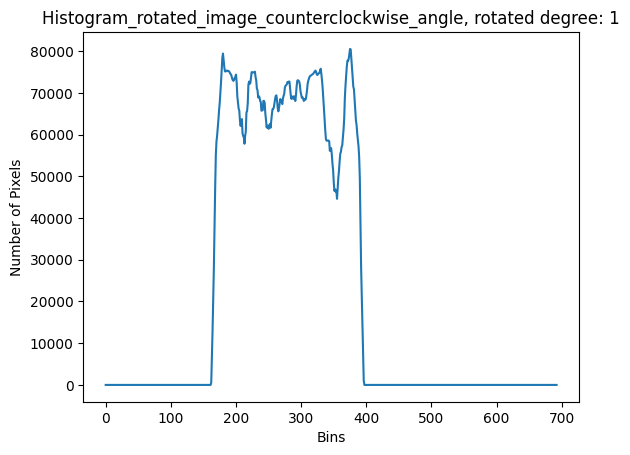

최대 픽셀 수 :  80553
돌아간 각도 :  1


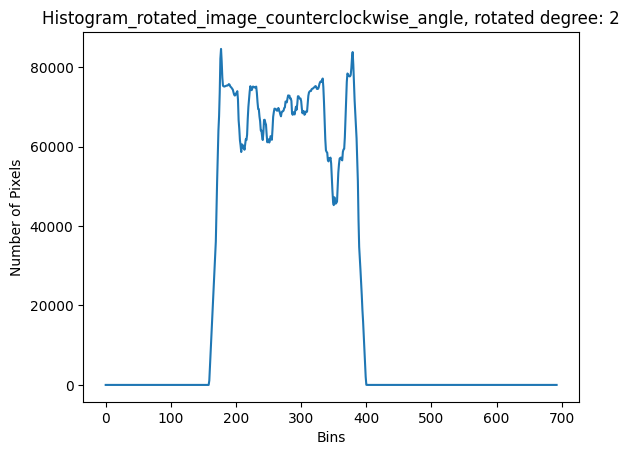

최대 픽셀 수 :  84595
돌아간 각도 :  2


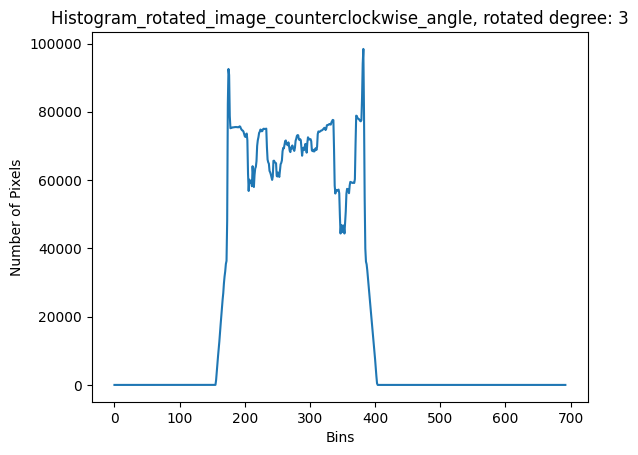

최대 픽셀 수 :  98412
돌아간 각도 :  3


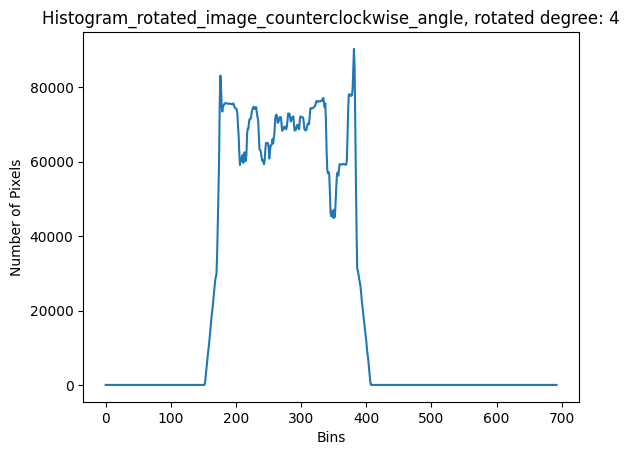

최대 픽셀 수 :  90342
돌아간 각도 :  4


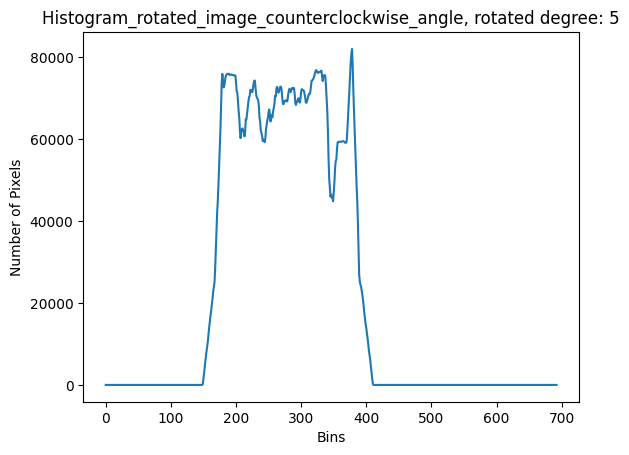

최대 픽셀 수 :  81969
돌아간 각도 :  5


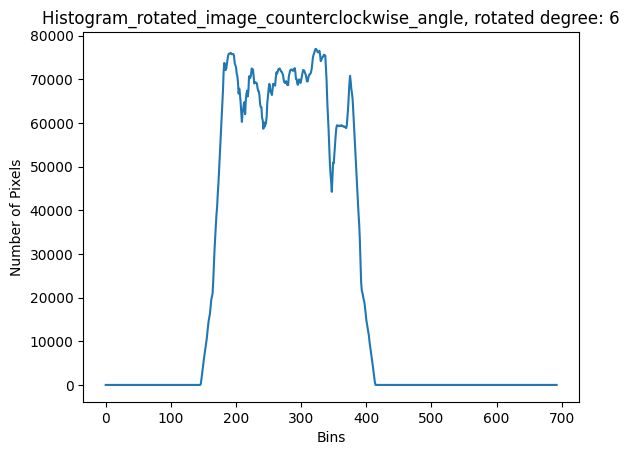

최대 픽셀 수 :  76979
돌아간 각도 :  6


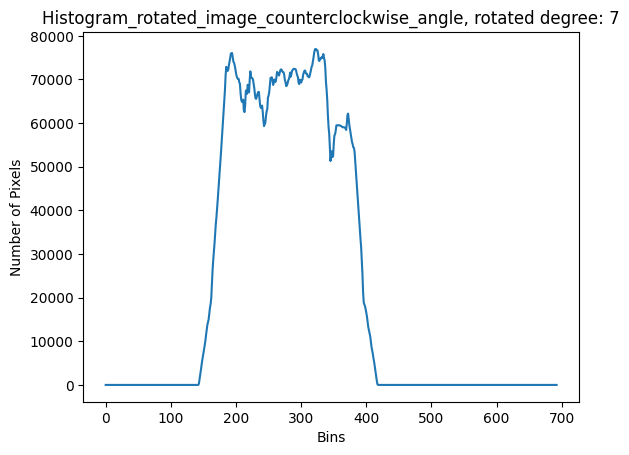

최대 픽셀 수 :  77006
돌아간 각도 :  7


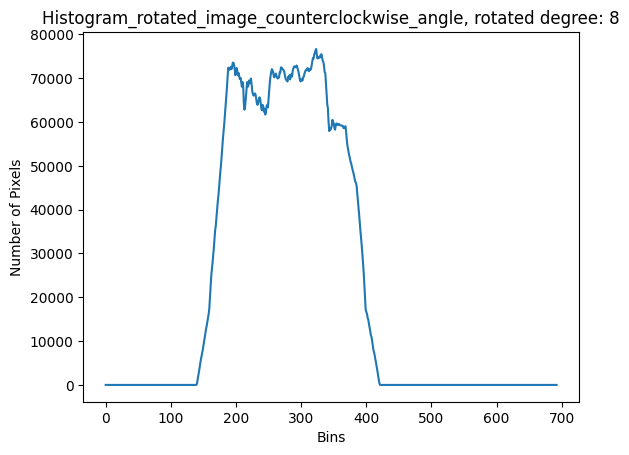

최대 픽셀 수 :  76677
돌아간 각도 :  8


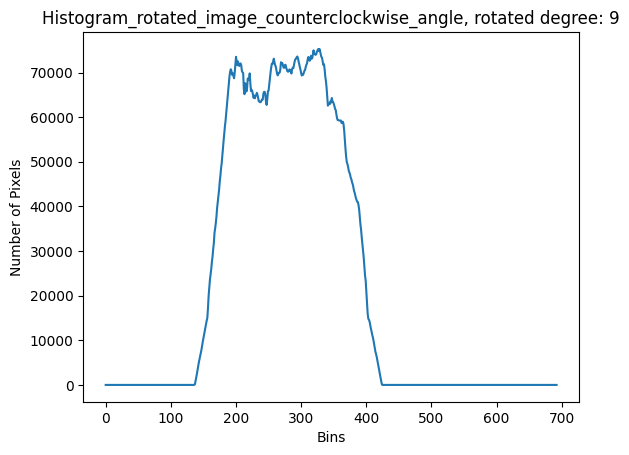

최대 픽셀 수 :  75288
돌아간 각도 :  9


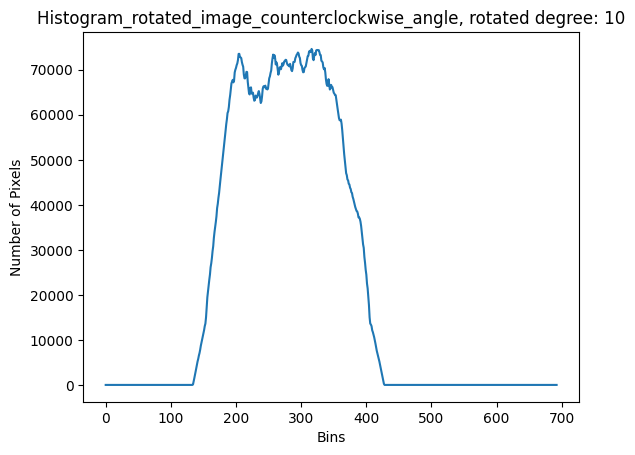

최대 픽셀 수 :  74626
돌아간 각도 :  10


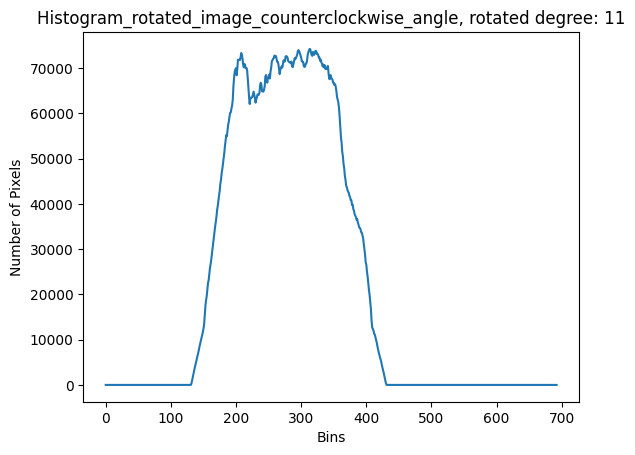

최대 픽셀 수 :  74258
돌아간 각도 :  11


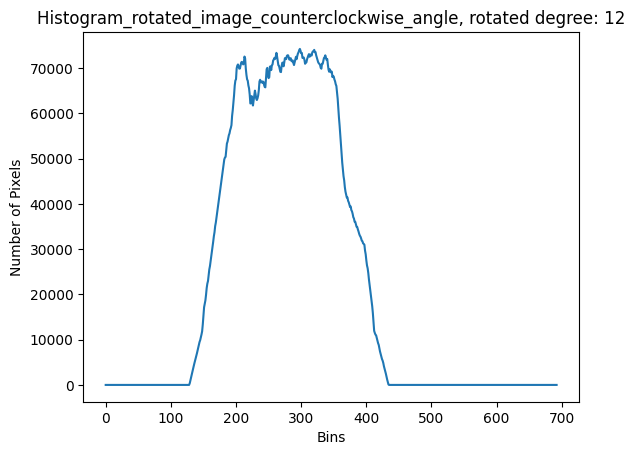

최대 픽셀 수 :  74232
돌아간 각도 :  12


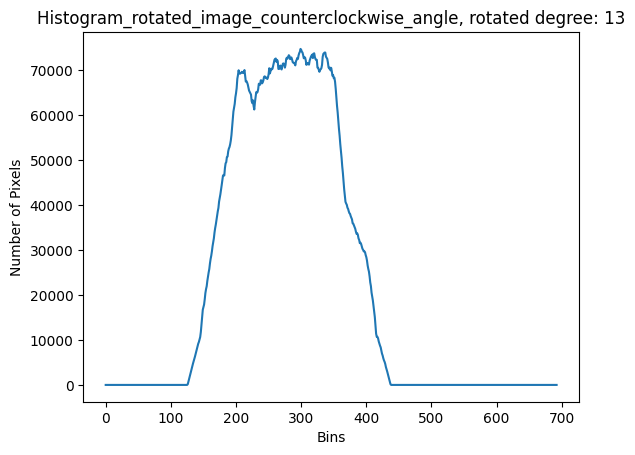

최대 픽셀 수 :  74742
돌아간 각도 :  13


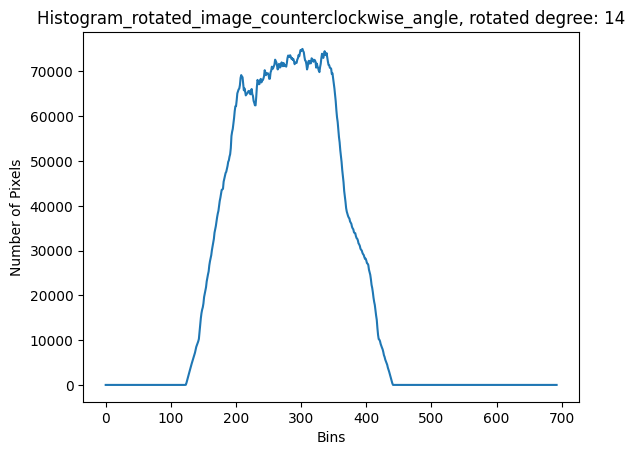

최대 픽셀 수 :  75029
돌아간 각도 :  14


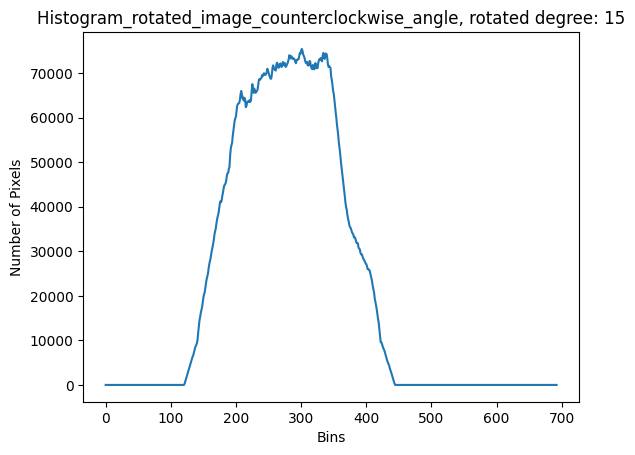

최대 픽셀 수 :  75425
돌아간 각도 :  15


In [12]:
# 2. 이미지를 반시계 방향으로 0도에서 15도까지 1도씩 회전하는 걸 반복
# x축 프로젝션 히스토그램의 max_peak값을 계속 저장하여 1도씩 돌아간 max_peak값 비교
# 가장 큰 max_peak값이 나왔을때가 정방향이라 가정
for i in range(16):
    M = angle_rotated_i = cv2.getRotationMatrix2D((cX, cY), i, 1)
    rotated_image = cv2.warpAffine(Backprojection_combined, M, (0, 0))
    rotate_x_projection = np.sum(rotated_image, axis=1)
    
    # 히스토그램 그래프에서 봉우리(peak) 값 찾기
    # 최대 peak 값을 찾기위해 모든 peak를 구하기 
    peaks_rotated_x, _ = find_peaks(rotate_x_projection.flatten(), prominence=0.1)
    peak_values_rotated_x = rotate_x_projection[peaks_rotated_x]

    # 가장 큰 봉우리 찾고 찾기
    # 모든 max_peak들을 서로 비교하기 위해 각각 max_peak_value_rotated_x[i]에 저장
    max_peak_value_rotated_x[i] = np.max(peak_values_rotated_x)
    # 몇 도 돌아갔을 때 가장 큰 값을 가지는지 확인하기위해서 i 값을 변수에 저장
    angle = i
    
    
    # 히스토그램 그래프 시각화
    plt.plot(rotate_x_projection)
    plt.title('Histogram_rotated_image_counterclockwise_angle, rotated degree: {}'.format(angle))
    plt.xlabel('Bins')  # 명암 값
    plt.ylabel('Number of Pixels')   # 픽셀 수
    plt.show()
    
    # max_peak_value_rotated_x 값이 궁금해서 출력하여 확인해봄 
    print("최대 픽셀 수 : ", max_peak_value_rotated_x[i])
    print("돌아간 각도 : ", angle)

최대 픽셀 값 : 98412
최대 픽셀 값일때의 돌아간 각도(양수 = 반시계방향, 음수 = 시계방향) : 3


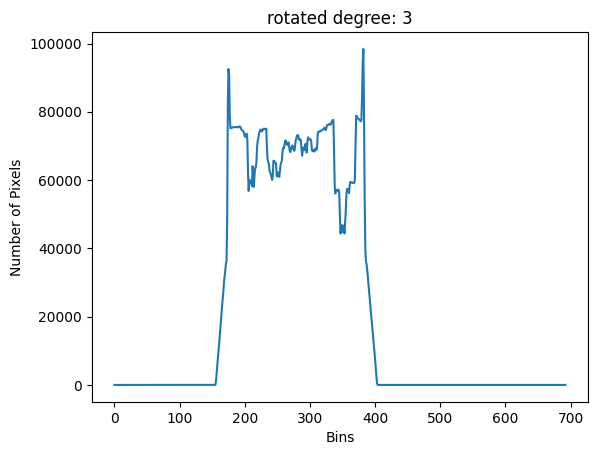

In [13]:
# 최대 픽셀 값일때의 돌아간 각도가 몇인지 확인하기 위해 최대 픽셀 값 측정 
print("최대 픽셀 값 : {}".format(max(max_peak_value_rotated_x)))

# 픽셀 값들의 봉우리의 값이 최대 픽셀 값과 같은 점의 인덱스 측정
optimum_degree = np.where(max_peak_value_rotated_x == max(max_peak_value_rotated_x))[0][0]

# 최대 픽셀 값일 때 돌아간 각도 출력
print("최대 픽셀 값일때의 돌아간 각도(양수 = 반시계방향, 음수 = 시계방향) : {}".format(optimum_degree))

# 최대 픽셀 값일 때 돌아간 각도를 기준으로 사진 출력해서 정방향이 맞는지 확인
M = angle_rotated_optimum = cv2.getRotationMatrix2D((cX, cY), optimum_degree, 1)
rotated_image = cv2.warpAffine(Backprojection_combined, M, (0, 0))
rotate_x_projection = np.sum(rotated_image, axis=1)
    
# 최대 값이 맞는지 확인하기 위해 히스토그램 그래프 시각화
plt.plot(rotate_x_projection)
plt.title('rotated degree: {}'.format(optimum_degree))
plt.xlabel('Bins')  # 명암 값
plt.ylabel('Number of Pixels')   # 픽셀 수
plt.show()

# 이미지로 확인
cv2.imshow("rotated_image", rotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
# 정방향으로 회전한 이미지에서 학번을 인식하기 위해 학생증만 잘라내기
# 학번을 잘 인식하기 위해 원본의 학생증과 비율을 동일하게 설정해야 함
w, h = src.shape[:2]
dh = 211   #  학생증의 가로 세로 = (366 X 211)
dw = int(dh * 1.75) 

# 네 꼭지점이 있는 사각형의 모양 변경 (찌그러뜨리기 or 팽팽하게 펴기)
src_resized = np.array([[approx[0, 0, :]], [approx[1, 0, :]], 
                        [approx[2, 0, :]], [approx[3, 0, :]]],dtype=np.float32)

# 좌측 하단, 좌측 상단, 우측 상단, 우측 하단 순서로 입력
dst_resized = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]]).astype(np.float32)

# getPerspectiveTransform(4개의 원본 좌표, 4개의 결과 좌표)
pers = cv2.getPerspectiveTransform(src_resized, dst_resized)
#  warpPerspective(입력,  getPerspective의 값, 출력이미지의 크기)
Perspective_Transform_image = cv2.warpPerspective(src, pers, (dw , dh), flags=cv2.INTER_CUBIC)

cv2.imshow('Perspective_Transform_image', Perspective_Transform_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
# 육안으로 편하게 확인해보기 위해 가로 세로 동일한 비율 유지하면서 확대해봄
Student_ID_resize = cv2.resize(Perspective_Transform_image, (0, 0), fx=3, fy=3)

cv2.imshow('Student_ID_resize', Student_ID_resize)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
# 학번 인식을 하기 위해 그레이로 채널을 바꾸고 이진화 시키기
# 흑백으로 변경
Perspective_Transform_image_gray = cv2.cvtColor(Perspective_Transform_image, cv2.COLOR_BGR2GRAY)

# 이진화 
ret, perspective_binary = cv2.threshold(Perspective_Transform_image_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU )

cv2.imshow('perspective_binary', perspective_binary)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
# 잘려진 학생증 이미지에서 학번부분만 한 번 더 잘라내기
# 잘라낼 영역의 크기
dh2 = 20
dw2 = int(dh2 * 4)

# 잘라내고자 하는 영역의 시작점 설정 (왼쪽 상단 모서리의 좌표)
start_x = 55
start_y = 115

# 영역을 잘라내기 위해 시작점과 끝점을 계산
end_x = start_x + dw2
end_y = start_y + dh2

# crop함수를 사용하여 Perspective_Transform_image에서 영역을 잘라내기
cropped_image = perspective_binary[start_y:end_y, start_x:end_x]

# 잘라낸 이미지를 화면에 표시
cv2.imshow('Cropped Image', cropped_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
# 육안으로 편하게 확인해보기 위해 가로 세로 동일한 비율 유지하면서 확대해봄
Student_ID = cv2.resize(cropped_image, (0, 0), fx=3, fy=3)

cv2.imshow('Student_ID', Student_ID)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
# 테서랙트로 학번을 인식 후 출력
test = pytesseract.image_to_string(Student_ID)
print(test)

219125136

